In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', '20190218.csv', '20190219.csv', 'accurate.xlsx', 'comments.txt', 'cst1.csv', 'cst2.csv', 'document.csv', 'dot.csv', 'dot_1.csv', 'dot_result.csv']


In [2]:
rcParams['figure.figsize'] = 16,4

### 读取数据

In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


### 数据预处理

In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

In [9]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [10]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133848 entries, 0 to 133847
Data columns (total 4 columns):
dot           133848 non-null object
dot_id        133848 non-null int64
order_date    133848 non-null datetime64[ns]
order_num     133848 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.1+ MB


### 创建特征

In [11]:
def create_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
#     dot_prep_1['season'] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([1,2,3]), ['season']] = 1
#     dot_prep_1.loc[dot_prep_1['month'].isin([4,5,6]), ['season']] = 2
#     dot_prep_1.loc[dot_prep_1['month'].isin([7,8,9]), ['season']] = 3
#     dot_prep_1.loc[dot_prep_1['month'].isin([10,11,12]), ['season']] = 4
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [12]:
dot_prep_feature = create_feature(dot_prep)

In [13]:
dot_prep_feature[dot_prep_feature['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
248,1,2017-12-08,67.0,2017,12,8,4,342,49,0,...,50.0,53.0,48.0,64.0,14.0,36.0,40.0,50.333333,45.8,43.571429
580,1,2017-12-09,47.0,2017,12,9,5,343,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,56.666667,56.4,47.428571
917,1,2017-12-10,29.0,2017,12,10,6,344,49,1,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,54.666667,53.0,49.000000
1108,1,2017-12-11,52.0,2017,12,11,0,345,50,0,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,47.666667,49.2,51.142857
1612,1,2017-12-12,45.0,2017,12,12,1,346,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,42.666667,49.0,49.428571
1777,1,2017-12-13,45.0,2017,12,13,2,347,50,0,...,45.0,52.0,29.0,47.0,67.0,50.0,53.0,42.000000,48.0,49.000000
2255,1,2017-12-14,48.0,2017,12,14,3,348,50,0,...,45.0,45.0,52.0,29.0,47.0,67.0,50.0,47.333333,43.6,47.857143
2581,1,2017-12-15,46.0,2017,12,15,4,349,50,0,...,48.0,45.0,45.0,52.0,29.0,47.0,67.0,46.000000,43.8,47.571429
2959,1,2017-12-16,42.0,2017,12,16,5,350,50,0,...,46.0,48.0,45.0,45.0,52.0,29.0,47.0,46.333333,47.2,44.571429
3285,1,2017-12-17,22.0,2017,12,17,6,351,50,1,...,42.0,46.0,48.0,45.0,45.0,52.0,29.0,45.333333,45.2,43.857143


In [14]:
dot_train = dot_prep_feature[: -(30 * 338)]
dot_test = dot_prep_feature[-(30 * 338) :]

In [15]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [16]:
# 统计特征
dot_prep_sta = dot_train.copy()
dot_prep_dayofweek = dot_prep_sta.groupby(['dot_id', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
dot_prep_day = dot_prep_sta.groupby(['dot_id', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()

dot_prep_tmp = pd.merge(dot_train, dot_prep_dayofweek, on = ['dot_id', 'dayofweek'], how = 'left')
dot_prep_stas = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot_id', 'day'], how = 'left')

dot_test_tmp = pd.merge(dot_test, dot_prep_dayofweek, on = ['dot_id', 'dayofweek'], how = 'left')
dot_test_stas = pd.merge(dot_test_tmp, dot_prep_day, on = ['dot_id', 'day'], how = 'left')

In [17]:
dot_prep_stas.isnull().sum()

dot            0
dot_id         0
order_date     0
order_num      0
year           0
month          0
day            0
dayofweek      0
dayofyear      0
weekofyear     0
weekofsun      0
holidays       0
lagging1       0
lagging2       0
lagging3       0
lagging4       0
lagging5       0
lagging6       0
lagging7       0
rolling3       0
rolling5       0
rolling7       0
week_mean      0
week_median    0
week_min       0
week_max       0
week_std       0
day_mean       0
day_median     0
day_min        0
day_max        0
day_std        0
dtype: int64

In [183]:
# dot_xtrain = dot_prep_stas.drop(['order_num'], axis = 1)
# dot_ytrain = dot_prep_stas['order_num']
# dot_xtest = dot_test_stas.drop(['order_num'], axis = 1)
# dot_ytest = dot_test_stas['order_num']

In [191]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [192]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,                   # [0,1]， 默认0.3
        "n_estimators": 3300,
        "max_depth": 5,                         # [0,∞]， 默认6
        "min_child_weight": 3,                  # [0,∞]， 默认1
        "gamma": 0.5,                             # [0,∞]， 默认0
        "subsample": 0.9,                       # (0,1]， 默认1
        "colsample_bytree": 0.8,                # (0,1]， 默认1
        "silent": 1,                            # 默认0， 输出信息
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [193]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-14 18:20:23
train_end :  2019-02-14 18:27:10
dot_id 	 0.035894454
year 	 0.00041926454
month 	 0.015864428
day 	 0.049513787
dayofweek 	 0.042805556
dayofyear 	 0.055505212
weekofyear 	 0.0056127347
weekofsun 	 0.002759031
holidays 	 0.01342999
lagging1 	 0.1043022
lagging2 	 0.087802105
lagging3 	 0.06942209
lagging4 	 0.07491311
lagging5 	 0.06843479
lagging6 	 0.07872706
lagging7 	 0.09268451
rolling3 	 0.07153194
rolling5 	 0.058588836
rolling7 	 0.07178891


In [194]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : y_pre})
    result['RMSE'] = RMSE(y_test, y_pre)
    result['MAE'] = MAE(y_test, y_pre)
    print("MAE : ", MAE(y_test, y_pre), " RMSE : ", RMSE(y_test, y_pre))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [195]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-14 18:27:10
predict_end :  2019-02-14 18:27:11
MAE :  21.233828323738578  RMSE :  70.54862859748302


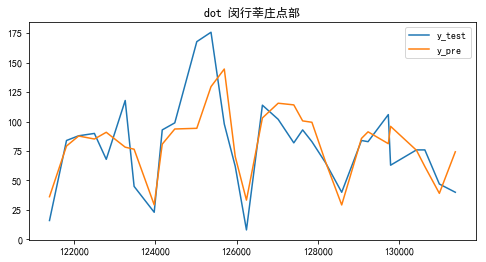

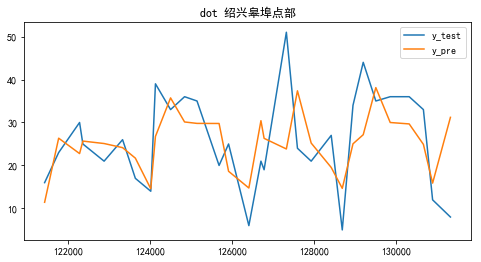

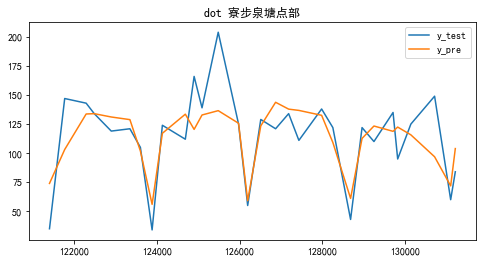

In [180]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

In [79]:
pre_date = pd.to_datetime(pd.date_range('2018-12-02', periods = 30, freq = 'D'))
pre_date

DatetimeIndex(['2018-12-02', '2018-12-03', '2018-12-04', '2018-12-05',
               '2018-12-06', '2018-12-07', '2018-12-08', '2018-12-09',
               '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13',
               '2018-12-14', '2018-12-15', '2018-12-16', '2018-12-17',
               '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21',
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='D')

In [196]:
dot_train[dot_train['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
248,1,2017-12-08,67.0,2017,12,8,4,342,49,0,...,50.0,53.0,48.0,64.0,14.0,36.0,40.0,50.333333,45.8,43.571429
580,1,2017-12-09,47.0,2017,12,9,5,343,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,56.666667,56.4,47.428571
917,1,2017-12-10,29.0,2017,12,10,6,344,49,1,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,54.666667,53.0,49.000000
1108,1,2017-12-11,52.0,2017,12,11,0,345,50,0,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,47.666667,49.2,51.142857
1612,1,2017-12-12,45.0,2017,12,12,1,346,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,42.666667,49.0,49.428571
1777,1,2017-12-13,45.0,2017,12,13,2,347,50,0,...,45.0,52.0,29.0,47.0,67.0,50.0,53.0,42.000000,48.0,49.000000
2255,1,2017-12-14,48.0,2017,12,14,3,348,50,0,...,45.0,45.0,52.0,29.0,47.0,67.0,50.0,47.333333,43.6,47.857143
2581,1,2017-12-15,46.0,2017,12,15,4,349,50,0,...,48.0,45.0,45.0,52.0,29.0,47.0,67.0,46.000000,43.8,47.571429
2959,1,2017-12-16,42.0,2017,12,16,5,350,50,0,...,46.0,48.0,45.0,45.0,52.0,29.0,47.0,46.333333,47.2,44.571429
3285,1,2017-12-17,22.0,2017,12,17,6,351,50,1,...,42.0,46.0,48.0,45.0,45.0,52.0,29.0,45.333333,45.2,43.857143


In [202]:
x_test_tmp = pd.DataFrame()
rolling_tmp = pd.DataFrame()
for dot in useful_dot_name['dot']:
    # lagging
    dot_test = dot_train.loc[dot_train['dot'] == dot]
    dot_test_ts = dot_test.copy()
    dot_test['lagging7'] = dot_test['lagging6']
    dot_test['lagging6'] = dot_test['lagging5']
    dot_test['lagging5'] = dot_test['lagging4']
    dot_test['lagging4'] = dot_test['lagging3']
    dot_test['lagging3'] = dot_test['lagging2']
    dot_test['lagging2'] = dot_test['lagging1']
    dot_test['lagging1'] = dot_test['order_num']
    
    x_test_tmp = pd.concat([x_test_tmp, dot_test])
    
    # rolling
    dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
    num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
    rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
#     rolling.index = rolling.index + pd.DateOffset(days = 1)
    rolling.columns = ['rolling3', 'rolling5', 'rolling7']
    rolling['dot'] = dot
    rolling['order_date'] = rolling.index
    rolling_tmp = pd.concat([rolling_tmp, rolling])

x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
# x_test.dropna(axis = 0, inplace = True)

# for i in range(30):
#     last_train_date = pd.to_datetime('2018-12-01')
#     x_test = x_test.loc[x_test['order_date'] == last_train_date, ['dot', 'dot_id', 'order_date', 'order_num', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7']]
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
#     x_test['year'] = dot_prep_1.order_date.dt.year
#     x_test['month'] = dot_prep_1.order_date.dt.month
#     x_test['day'] = dot_prep_1.order_date.dt.day
#     x_test['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
#     x_test['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
#     x_test['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
#     weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
#     x_test['weekofsun'] = 0
#     x_test.loc[x_test['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
#     x_test['holidays'] = 0
#     x_test.loc[x_test['order_date'].isin(
#     pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
#                     '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
#                     '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
#                     '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
#                     '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
#                     '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
#                     '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
#                     '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
#                     '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
#                     '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
#                     '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
#                     '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
#     y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
#     result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_pre' : y_pre})
    

In [203]:
x_test[x_test['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
0,1,2017-12-09,67.0,2017,12,8,4,342,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,NaN,NaN,NaN
1,1,2017-12-10,47.0,2017,12,9,5,343,49,0,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,NaN,NaN,NaN
2,1,2017-12-11,29.0,2017,12,10,6,344,49,1,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,47.666667,NaN,NaN
3,1,2017-12-12,52.0,2017,12,11,0,345,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,42.666667,NaN,NaN
4,1,2017-12-13,45.0,2017,12,12,1,346,50,0,...,45.0,52.0,29.0,47.0,67.0,50.0,53.0,42.000000,48.0,NaN
5,1,2017-12-14,45.0,2017,12,13,2,347,50,0,...,45.0,45.0,52.0,29.0,47.0,67.0,50.0,47.333333,43.6,NaN
6,1,2017-12-15,48.0,2017,12,14,3,348,50,0,...,48.0,45.0,45.0,52.0,29.0,47.0,67.0,46.000000,43.8,47.571429
7,1,2017-12-16,46.0,2017,12,15,4,349,50,0,...,46.0,48.0,45.0,45.0,52.0,29.0,47.0,46.333333,47.2,44.571429
8,1,2017-12-17,42.0,2017,12,16,5,350,50,0,...,42.0,46.0,48.0,45.0,45.0,52.0,29.0,45.333333,45.2,43.857143
9,1,2017-12-18,22.0,2017,12,17,6,351,50,1,...,22.0,42.0,46.0,48.0,45.0,45.0,52.0,36.666667,40.6,42.857143


In [124]:
dot_train_tmp = dot_train.loc[dot_train['dot'] == '东丽机场点部']
dot_train_tmp.drop(['dot', 'rolling3'], axis = 1).head()

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling5,rolling7,rolling8
248,1,2017-12-08,67.0,2017,12,8,4,342,49,0,...,50.0,53.0,48.0,64.0,14.0,36.0,40.0,56.4,47.428571,46.500
580,1,2017-12-09,47.0,2017,12,9,5,343,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,53.0,49.000000,47.375
917,1,2017-12-10,29.0,2017,12,10,6,344,49,1,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,49.2,51.142857,46.500
1108,1,2017-12-11,52.0,2017,12,11,0,345,50,0,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,49.0,49.428571,51.250
1612,1,2017-12-12,45.0,2017,12,12,1,346,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,48.0,49.000000,48.875


In [116]:
last_train_date = pd.to_datetime('2018-12-01')

In [119]:
dot_test = dot_train.loc[dot_train['order_date'] == last_train_date, ['dot', 'dot_id', 'order_date', 'order_num', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']]
dot_test['order_date'] = dot_test['order_date'] + pd.DateOffset(days = 1)
dot_test.head()

,dot,dot_id,order_date,order_num,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7
121228,淀山湖石浦点部,211,2018-12-02,40.0,36.0,35.0,21.0,27.0,34.0,7.0,28.0
121229,青浦纪王点部,319,2018-12-02,402.0,1431.0,2025.0,1486.0,1103.0,450.0,148.0,205.0
121233,郑州经开点部,295,2018-12-02,13.0,8.0,19.0,26.0,15.0,13.0,5.0,6.0
121231,奉贤泰日点部,106,2018-12-02,39.0,39.0,64.0,64.0,62.0,82.0,11.0,43.0
121232,甪直南港点部,236,2018-12-02,44.0,56.0,90.0,51.0,71.0,60.0,21.0,65.0


In [ ]:
dot_test['lagging7'] = dot_test['lagging6']

In [31]:
test_X.drop(['dot'], axis = 1).tail()

,dot_id,order_date,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7
121114,243,2018-12-01,2018,12,1,5,335,48,0,0,70.0,19.0,56.0,42.0,36.0,7.0,24.0
121111,324,2018-12-01,2018,12,1,5,335,48,0,0,46.0,45.0,38.0,43.0,43.0,21.0,43.0
121116,26,2018-12-01,2018,12,1,5,335,48,0,0,47.0,41.0,52.0,69.0,69.0,40.0,56.0
121117,43,2018-12-01,2018,12,1,5,335,48,0,0,56.0,50.0,73.0,83.0,50.0,20.0,53.0
121115,55,2018-12-01,2018,12,1,5,335,48,0,0,40.0,17.0,39.0,39.0,32.0,6.0,19.0


In [32]:
test_X['order_date'] = test_X['order_date'] + pd.DateOffset(days = 1)
test_X['lagging7'] = test_X['lagging6']
test_X['lagging6'] = test_X['lagging5']
test_X['lagging5'] = test_X['lagging4']
test_X['lagging4'] = test_X['lagging3']
test_X['lagging3'] = test_X['lagging2']
test_X['lagging2'] = test_X['lagging1']
test_X['lagging1'] = test_y['order_num']

In [33]:
test_X.drop(['dot'], axis = 1).tail()

,dot_id,order_date,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,holidays,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7
121114,243,2018-12-02,2018,12,1,5,335,48,0,0,21.0,70.0,19.0,56.0,42.0,36.0,7.0
121111,324,2018-12-02,2018,12,1,5,335,48,0,0,32.0,46.0,45.0,38.0,43.0,43.0,21.0
121116,26,2018-12-02,2018,12,1,5,335,48,0,0,37.0,47.0,41.0,52.0,69.0,69.0,40.0
121117,43,2018-12-02,2018,12,1,5,335,48,0,0,45.0,56.0,50.0,73.0,83.0,50.0,20.0
121115,55,2018-12-02,2018,12,1,5,335,48,0,0,12.0,40.0,17.0,39.0,39.0,32.0,6.0


In [43]:
for i in range(len(pre_date)):
    order_date = pre_date[i]
    test_X['order_date'] = test_X['order_date'] + pd.DateOffset(days = 1)
    test_X['lagging7'] = test_X['lagging6']
    test_X['lagging6'] = test_X['lagging5']
    test_X['lagging5'] = test_X['lagging4']
    test_X['lagging4'] = test_X['lagging3']
    test_X['lagging3'] = test_X['lagging2']
    test_X['lagging2'] = test_X['lagging1']
    test_X['lagging1'] = dot_ytrain
    
    
    

In [ ]:
# 验证
dot_train['order_date'] = dot_train['order_date'] + pd.DateOffset(days = 1)
dot_train['lagging7'] = dot_train['lagging6']
dot_train['lagging6'] = dot_train['lagging5']
dot_train['lagging5'] = dot_train['lagging4']
dot_train['lagging4'] = dot_train['lagging3']
dot_train['lagging3'] = dot_train['lagging2']
dot_train['lagging2'] = dot_train['lagging1']
dot_train['lagging1'] = dot_train['order_num']

print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
for order_date in x_test['order_date'].unique():
    test_X = dot_train[dot_train['order_date'] == order_date]
    y_pre = gbm.predict(test_X.drop(['dot', 'order_date', 'order_num'], axis = 1))

    dot_train['lagging7'] = dot_train['lagging6']
    dot_train['lagging6'] = dot_train['lagging5']
    dot_train['lagging5'] = dot_train['lagging4']
    dot_train['lagging4'] = dot_train['lagging3']
    dot_train['lagging3'] = dot_train['lagging2']
    dot_train['lagging2'] = dot_train['lagging1']
    dot_train['lagging1'] = y_pre

    dot_train['order_date'] = dot_train['order_date'] + pd.DateOffset(days = 1)
